## Building a Recommender System Architectures

In [2]:
import os
import torch
import pandas as pd
import numpy as np
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Load the embedded data
file_path = '/content/drive/MyDrive/Companies Interview Projects/InShorts/cleaned_data/user_news_embed_data.pkl'

df = pd.read_pickle(file_path)

In [5]:
X = df[['user_embed', 'news_embed']]
y = df['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

# Define Dataset

class TwoTowerMNRDataset(Dataset):
    def __init__(self, user_embeds, news_embeds, labels, all_news_embeds):
        """
        Dataset for Two-Tower MNR training (optimized for pickle-stored embeddings).
        """
        # Directly stack numpy arrays (since pickle preserves array format)
        self.user_embeds = torch.tensor(np.stack(user_embeds), dtype=torch.float32)
        self.pos_news_embeds = torch.tensor(np.stack(news_embeds), dtype=torch.float32)
        self.all_news_embeds = torch.tensor(np.stack(all_news_embeds), dtype=torch.float32)

        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.num_news = len(self.all_news_embeds)

    def __len__(self):
        return len(self.user_embeds)

    def __getitem__(self, idx):
        user_vec = self.user_embeds[idx]
        pos_news_vec = self.pos_news_embeds[idx]

        # Randomly sample a negative news embedding
        neg_idx = np.random.randint(0, self.num_news)
        neg_news_vec = self.all_news_embeds[neg_idx]

        return user_vec, pos_news_vec, neg_news_vec

In [6]:
# Load from pickle
# Load the stored embeddings
user_embed_df = pd.read_pickle("/content/drive/MyDrive/Companies Interview Projects/InShorts/cleaned_data/user_embed_df.pkl")
news_embed_df = pd.read_pickle("/content/drive/MyDrive/Companies Interview Projects/InShorts/cleaned_data/news_embed_df.pkl")

# Create Dataset and DataLoader

train_dataset = TwoTowerMNRDataset(
    X_train['user_embed'].values,
    X_train['news_embed'].values,
    y_train,
    all_news_embeds=news_embed_df['news_embed'].values
)

test_dataset = TwoTowerMNRDataset(
    X_test['user_embed'].values,
    X_test['news_embed'].values,
    y_test,
    all_news_embeds=news_embed_df['news_embed'].values
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"✅ Train batches: {len(train_loader)} | Test batches: {len(test_loader)}")

✅ Train batches: 1219 | Test batches: 407


In [7]:
class UserTower(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embed_dim)
        )
    def forward(self, x):
        return F.normalize(self.fc(x), p=2, dim=1)

class NewsTower(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embed_dim)
        )
    def forward(self, x):
        return F.normalize(self.fc(x), p=2, dim=1)

class TwoTowerModel(nn.Module):
    def __init__(self, user_input_dim, news_input_dim, embed_dim):
        super().__init__()
        self.user_tower = UserTower(user_input_dim, embed_dim)
        self.news_tower = NewsTower(news_input_dim, embed_dim)

    def forward(self, user_x, news_x):
      user_embed = self.user_tower(user_x)
      news_embed = self.news_tower(news_x)
      # element-wise similarity
      score = (user_embed * news_embed).sum(dim=1, keepdim=True)
      return score, user_embed, news_embed

In [8]:
#Trainable with MNR Loss
def train_two_tower_mnr(
    model, train_loader, test_loader, optimizer, device,
    num_epochs=10, margin=0.2, patience=3, model_name='two_tower_mnr'
):
    """
    Train a Two-Tower model using Margin Ranking Loss (MNR) with tracking of
    train/validation loss and accuracy for plotting.
    """
    model.to(device)
    criterion = nn.MarginRankingLoss(margin=margin)
    best_loss = float('inf')
    epochs_no_improve = 0

    # For plotting
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        # ------------------ TRAIN ------------------
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for user_vec, pos_news_vec, neg_news_vec in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Move to device
            user_vec, pos_news_vec, neg_news_vec = user_vec.to(device), pos_news_vec.to(device), neg_news_vec.to(device)

            optimizer.zero_grad()

            # Forward
            user_emb = model.user_tower(user_vec)
            pos_news_emb = model.news_tower(pos_news_vec)
            neg_news_emb = model.news_tower(neg_news_vec)

            # Similarity scores
            pos_scores = torch.sum(user_emb * pos_news_emb, dim=1)
            neg_scores = torch.sum(user_emb * neg_news_emb, dim=1)

            # Margin Ranking Loss
            target = torch.ones_like(pos_scores)
            loss = criterion(pos_scores, neg_scores, target)

            # Backprop
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * user_vec.size(0)

            # Accuracy (pos_score > neg_score)
            correct += torch.sum(pos_scores > neg_scores).item()
            total += user_vec.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # ------------------ VALIDATION ------------------
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for user_vec, pos_news_vec, neg_news_vec in test_loader:
                user_vec, pos_news_vec, neg_news_vec = user_vec.to(device), pos_news_vec.to(device), neg_news_vec.to(device)

                user_emb = model.user_tower(user_vec)
                pos_news_emb = model.news_tower(pos_news_vec)
                neg_news_emb = model.news_tower(neg_news_vec)

                pos_scores = torch.sum(user_emb * pos_news_emb, dim=1)
                neg_scores = torch.sum(user_emb * neg_news_emb, dim=1)
                target = torch.ones_like(pos_scores)
                loss = criterion(pos_scores, neg_scores, target)

                val_loss += loss.item() * user_vec.size(0)
                correct += torch.sum(pos_scores > neg_scores).item()
                total += user_vec.size(0)

        avg_val_loss = val_loss / len(test_loader.dataset)
        val_acc = correct / total

        # Save stats
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # --- Early Stopping ---
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), f"/content/drive/MyDrive/Companies Interview Projects/InShorts/model/{model_name}_best.pth")
            print(f"✅ Best model saved (Val Loss: {best_loss:.4f})")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("⛔ Early stopping triggered")
                break



    return model, history

In [9]:
# Initialize the model
user_input_dim = len(df['user_embed'].iloc[0])
news_input_dim = len(df['news_embed'].iloc[0])
embed_dim = 128  # tunable

print(user_input_dim, news_input_dim,embed_dim)

model = TwoTowerModel(user_input_dim, news_input_dim, embed_dim)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train
model, history = train_two_tower_mnr(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    num_epochs=10,
    margin=0.2,
    patience=3,
    model_name='two_tower_mnr'
)

30 407 128


Epoch 1/10: 100%|██████████| 1219/1219 [00:13<00:00, 89.66it/s] 


Epoch 1/10 | Train Loss: 0.1297 | Val Loss: 0.1249 | Train Acc: 0.7041 | Val Acc: 0.7190
✅ Best model saved (Val Loss: 0.1249)


Epoch 2/10: 100%|██████████| 1219/1219 [00:13<00:00, 87.35it/s]


Epoch 2/10 | Train Loss: 0.1209 | Val Loss: 0.1198 | Train Acc: 0.7269 | Val Acc: 0.7281
✅ Best model saved (Val Loss: 0.1198)


Epoch 3/10: 100%|██████████| 1219/1219 [00:14<00:00, 83.80it/s]


Epoch 3/10 | Train Loss: 0.1158 | Val Loss: 0.1160 | Train Acc: 0.7414 | Val Acc: 0.7419
✅ Best model saved (Val Loss: 0.1160)


Epoch 4/10: 100%|██████████| 1219/1219 [00:15<00:00, 79.96it/s]


Epoch 4/10 | Train Loss: 0.1110 | Val Loss: 0.1131 | Train Acc: 0.7538 | Val Acc: 0.7497
✅ Best model saved (Val Loss: 0.1131)


Epoch 5/10: 100%|██████████| 1219/1219 [00:15<00:00, 76.86it/s]


Epoch 5/10 | Train Loss: 0.1069 | Val Loss: 0.1094 | Train Acc: 0.7630 | Val Acc: 0.7578
✅ Best model saved (Val Loss: 0.1094)


Epoch 6/10: 100%|██████████| 1219/1219 [00:13<00:00, 88.72it/s]


Epoch 6/10 | Train Loss: 0.1032 | Val Loss: 0.1071 | Train Acc: 0.7719 | Val Acc: 0.7613
✅ Best model saved (Val Loss: 0.1071)


Epoch 7/10: 100%|██████████| 1219/1219 [00:15<00:00, 80.16it/s]


Epoch 7/10 | Train Loss: 0.1003 | Val Loss: 0.1044 | Train Acc: 0.7801 | Val Acc: 0.7687
✅ Best model saved (Val Loss: 0.1044)


Epoch 8/10: 100%|██████████| 1219/1219 [00:13<00:00, 87.72it/s]


Epoch 8/10 | Train Loss: 0.0970 | Val Loss: 0.1041 | Train Acc: 0.7883 | Val Acc: 0.7702
✅ Best model saved (Val Loss: 0.1041)


Epoch 9/10: 100%|██████████| 1219/1219 [00:15<00:00, 80.55it/s]


Epoch 9/10 | Train Loss: 0.0955 | Val Loss: 0.1016 | Train Acc: 0.7924 | Val Acc: 0.7759
✅ Best model saved (Val Loss: 0.1016)


Epoch 10/10: 100%|██████████| 1219/1219 [00:13<00:00, 90.39it/s]


Epoch 10/10 | Train Loss: 0.0939 | Val Loss: 0.1022 | Train Acc: 0.7945 | Val Acc: 0.7765


### Plot: Epochs vs Train Loss and Test

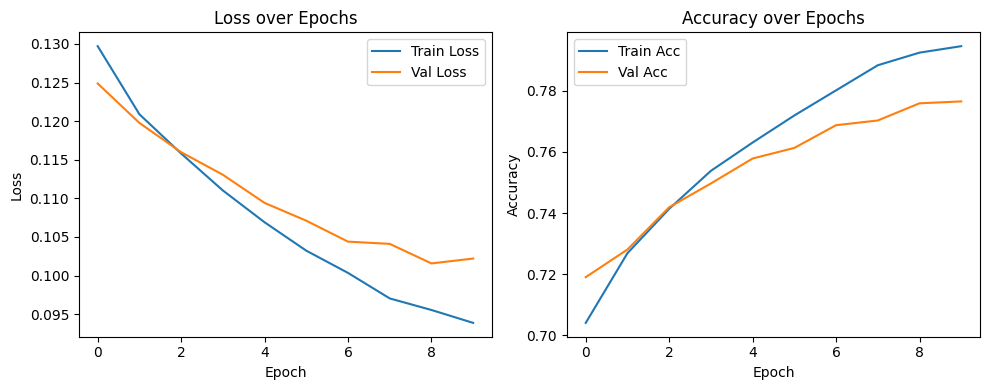

In [10]:
# ------------------ PLOTTING ------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Make predictions using our model

In [11]:
df_test = pd.read_csv('/content/drive/MyDrive/Companies Interview Projects/InShorts/cleaned_data/test_content_cleaned_data.csv')

In [12]:
df_test.head(5)

,hashid,title,content,newsType,author,categories,createdAt,updatedAt,newsLanguage,sourceName
0,zdw0jrig-1,Redmi 12 5G will be a game-changer for 5G conn...,Xiaomi will debut Redmi 12 5G alongside Redmi ...,NEWS,593f9d1f81ef171ab3b63a2d,technology,2023-07-27T07:06:41.000Z,2023-07-27T07:06:41.000Z,english,Xiaomi
1,y5pfnbmp-1,Limited seats left for Hero Vired & MIT’s Prog...,Hero Group's EdTech company Hero Vired & MIT l...,NEWS,593f9d1f81ef171ab3b63a2d,education,2023-07-27T04:30:50.000Z,2023-07-27T04:30:50.000Z,english,vired.com
2,eo2eyhgk-1,Heavy to very heavy rainfall warning issued fo...,IMD has issued heavy to very heavy rainfall wa...,NEWS,5f70de9bd43821580e6d7022,national,2023-07-27T16:23:53.000Z,2023-07-27T17:12:11.285Z,english,IMD
3,fknyydal-1,Which 14 teams have qualified for 20-team T20 ...,Ireland and Scotland have qualified for the 20...,NEWS,5f70de9bd43821580e6d7022,sports,2023-07-27T14:29:59.000Z,2023-07-27T14:29:59.000Z,english,ICC
4,61ogen4w-1,42-year-old woman shot dead near her house in ...,A 42-year-old woman was shot dead near her hou...,NEWS,5f70de9bd43821580e6d7022,national,2023-07-27T17:07:31.000Z,2023-07-27T17:07:31.000Z,english,ABP


In [13]:
# Load Trained Model and Data

model_path = "/content/drive/MyDrive/Companies Interview Projects/InShorts/model/two_tower_mnr_best.pth"

# Assuming your model class is named TwoTowerModel
model = TwoTowerModel(user_input_dim, news_input_dim, embed_dim)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Load your user and news data (pickles or CSV)
user_df = pd.read_pickle("/content/drive/MyDrive/Companies Interview Projects/InShorts/cleaned_data/user_embed_df.pkl")
news_df = pd.read_pickle("/content/drive/MyDrive/Companies Interview Projects/InShorts/cleaned_data/test_news_embed_df.pkl")

In [14]:
# Generate News Embeddings

def get_news_embeddings(news_df, model, device):
    """Generate embeddings for all news using the news tower."""
    model.eval()
    news_embeddings = []

    for i in tqdm(range(len(news_df))):
        # Assuming news_embed column contains numpy arrays
        if 'news_embed' in news_df.columns:
            vec = torch.tensor(news_df.iloc[i]['news_embed'], dtype=torch.float32).unsqueeze(0).to(device)
        else:
            # If you have raw text, plug in your text encoder here (e.g. SentenceTransformer)
            raise ValueError("news_embed column or encoder not found!")

        with torch.no_grad():
            emb = model.news_tower(vec)
        news_embeddings.append(emb.cpu().numpy().squeeze())

    return np.stack(news_embeddings)

# Generate all news embeddings
news_embeddings = get_news_embeddings(news_df, model, device)
news_df["news_embedding"] = list(news_embeddings)

100%|██████████| 1346/1346 [00:00<00:00, 3683.35it/s]


In [15]:
# Generate Final User Embeddings
def get_user_embeddings(user_df, model, device):
    """Generate final user tower embeddings."""
    model.eval()
    user_embeddings = []

    for i in tqdm(range(len(user_df))):
        if 'user_embed' in user_df.columns:
            vec = torch.tensor(user_df.iloc[i]['user_embed'], dtype=torch.float32).unsqueeze(0).to(device)
        else:
            raise ValueError("user_embed column not found!")

        with torch.no_grad():
            emb = model.user_tower(vec)
        user_embeddings.append(emb.cpu().numpy().squeeze())

    return np.stack(user_embeddings)


# Generate final user embeddings
user_embeddings = get_user_embeddings(user_df, model, device)
user_df["final_user_embed"] = list(user_embeddings)

print("✅ Generated user tower embeddings:", user_df.shape)
print("✅ Generated news tower embeddings:", news_df.shape)

100%|██████████| 10400/10400 [00:02<00:00, 4102.37it/s]


✅ Generated user tower embeddings: (10400, 3)
✅ Generated news tower embeddings: (1346, 3)


In [16]:
# Compute Similarity Scores (Dot Product)

from sklearn.metrics.pairwise import cosine_similarity

# Convert list of embeddings to numpy arrays
user_matrix = np.stack(user_df["final_user_embed"].values)
news_matrix = np.stack(news_df["news_embedding"].values)

# Compute cosine similarity (U x N matrix)
similarity_matrix = cosine_similarity(user_matrix, news_matrix)

print(f"✅ Similarity matrix shape: {similarity_matrix.shape}")

✅ Similarity matrix shape: (10400, 1346)


In [ ]:
# Generate Top-K Recommendations

top_k = 5  # number of news articles to recommend per user

recommendations = []
for user_idx, user_id in enumerate(user_df["deviceId"].values):
    top_indices = np.argsort(similarity_matrix[user_idx])[::-1][:top_k]
    top_news_ids = news_df.iloc[top_indices]["hashId"].values
    recommendations.append({"deviceId": user_id, "recommended_news": top_news_ids})

recommendations_df = pd.DataFrame(recommendations)
print("✅ Recommendations ready!")
print(recommendations_df.head())

# Optional: Save to disk
recommendations_df.to_pickle(
    "/content/drive/MyDrive/Companies Interview Projects/InShorts/recommendations_df.pkl"
)
print("✅ Saved recommendations to pickle file!")

✅ Recommendations ready!
                               deviceId  \
0  197b123e-eb9e-4fc1-a32d-aa86aaea425e   
1  3c33c537-7c6c-40f5-835c-f997e883cae2   
2  6c7be5d0-d4d8-469f-91be-8055021ceef9   
3  0801af66-0a6f-4fdd-82a9-c2b15757b8f5   
4  78b3c7a7-5881-42dc-9f8e-b4fc27f94360   

                                    recommended_news  
0  [xrykhbnc-1, 6njg1tj7-1, qimljpxb-1, cyd0ierx-...  
1  [xrykhbnc-1, 6njg1tj7-1, qimljpxb-1, cyd0ierx-...  
2  [6njg1tj7-1, xrykhbnc-1, a1xswwcm-1, umg31ldy-...  
3  [xrykhbnc-1, n9lyehhv-1, 6njg1tj7-1, 5zxzuwaa-...  
4  [xrykhbnc-1, cyd0ierx-1, 6njg1tj7-1, qimljpxb-...  
✅ Saved recommendations to pickle file!


## Implementing New Architectute - Sequential Model

In [17]:
def generate_candidates(user_df, news_df, similarity_matrix, top_k=50):
    """
    Generate top-K news recommendations for each user based on similarity.
    Returns a candidate dataframe ready for Content-Based filtering.
    """
    recommendations = []
    for user_idx, user_id in enumerate(user_df["deviceId"].values):
        # Get top-K most similar news articles
        top_indices = np.argsort(similarity_matrix[user_idx])[::-1][:top_k]
        top_news = news_df.iloc[top_indices].copy()

        # Add metadata for re-ranking
        top_news["deviceId"] = user_id
        top_news["two_tower_score"] = similarity_matrix[user_idx][top_indices]

        recommendations.append(top_news)

    # Merge all user recommendations into one dataframe
    candidates_df = pd.concat(recommendations, ignore_index=True)
    return candidates_df

# Generate candidate pool
candidates_df = generate_candidates(user_df, news_df, similarity_matrix, top_k=25)
print(f"✅ Candidate pool shape: {candidates_df.shape}")

# ---------------------------------------------
# STEP 5: Save Candidate Pool
# ---------------------------------------------
candidates_df.to_pickle("/content/drive/MyDrive/Companies Interview Projects/InShorts/recommendation/candidates_df.pkl")
print("✅ Saved Two-Tower candidate pool!")

✅ Candidate pool shape: (520000, 5)
✅ Saved Two-Tower candidate pool!


In [18]:
candidates_df.columns

Index(['hashId', 'news_embed', 'news_embedding', 'deviceId',
       'two_tower_score'],
      dtype='object')

In [19]:
def rerank_user_cbf_with_history(user_id, user_embedding_df, user_history_df, candidates_df):
    """
    Re-rank candidate news for a single user using semantic similarity with user embedding + history.

    Args:
        user_id (str): target user ID
        user_embedding_df (pd.DataFrame): ['deviceId', 'final_user_embed']
        user_history_df (pd.DataFrame): ['deviceId', 'user_history'] -> list of hashIds
        candidates_df (pd.DataFrame): candidate news for the user ['hashId', 'news_embedding', 'two_tower_score']

    Returns:
        pd.DataFrame: re-ranked news for the user
    """
    # --- 1️⃣ Get user embedding ---
    try:
        user_emb = np.array(user_embedding_df.loc[user_embedding_df["deviceId"] == user_id, "final_user_embed"].values[0])
    except IndexError:
        return pd.DataFrame()

    # --- 2️⃣ Aggregate user history embeddings ---
    user_history_hashes = user_history_df.loc[user_history_df["deviceId"] == user_id, "user_history_embed"].values
    user_history_hashes = user_history_hashes[0] if len(user_history_hashes) > 0 else []

    if len(user_history_hashes) > 0:
        # Fetch embeddings of all news in user's history
        history_embeddings = candidates_df.loc[
            candidates_df["hashId"].isin(user_history_hashes), "news_embedding"
        ].values
        if len(history_embeddings) > 0:
            history_emb_matrix = np.vstack(history_embeddings)
            history_emb_avg = history_emb_matrix.mean(axis=0)
        else:
            history_emb_avg = np.zeros_like(user_emb)
    else:
        history_emb_avg = np.zeros_like(user_emb)

    # --- 3️⃣ Combine user embedding + history embedding ---
    user_repr = user_emb + history_emb_avg

    # --- 4️⃣ Compute semantic similarity with candidate news ---
    news_embeds = np.vstack(candidates_df["news_embedding"].values)
    semantic_scores = cosine_similarity(user_repr.reshape(1, -1), news_embeds).flatten()

    # --- 5️⃣ Prepare output ---
    ranked_df = candidates_df.copy()
    ranked_df["cbf_score"] = semantic_scores
    ranked_df["deviceId"] = user_id
    ranked_df = ranked_df.sort_values("cbf_score", ascending=False).reset_index(drop=True)

    return ranked_df[["deviceId", "hashId", "cbf_score", "two_tower_score", "news_embedding"]]


def rerank_all_users_cbf_with_history(user_embedding_df, user_history_df, candidates_df):
    """
    Re-rank all users' candidate news using semantic similarity with user embedding + history.
    Output is ready for collaborative filtering.
    """
    all_ranked = []

    for user_id in tqdm(user_embedding_df["deviceId"].values, desc="Re-ranking users (Semantic + History)"):
        user_candidates = candidates_df[candidates_df["deviceId"] == user_id].copy()
        if user_candidates.empty:
            continue

        ranked_user_df = rerank_user_cbf_with_history(
            user_id, user_embedding_df, user_history_df, user_candidates
        )
        if not ranked_user_df.empty:
            all_ranked.append(ranked_user_df)

    if not all_ranked:
        print("⚠️ No valid users for CBF re-ranking.")
        return pd.DataFrame()

    final_ranked_df = pd.concat(all_ranked, ignore_index=True)
    print(f"✅ Completed CBF re-ranking for {len(all_ranked)} users")

    return final_ranked_df

In [20]:
user_history_df = pd.read_pickle("/content/drive/MyDrive/Companies Interview Projects/InShorts/cleaned_data/user_history_df.pkl")
# --- Single user re-ranking ---
# target_user = "user_123"
# user_ranked = rerank_user_cbf(target_user, user_df, candidates_df, interaction_df)
# print(user_ranked.head())

# --- All users re-ranking ---
all_ranked_df = rerank_all_users_cbf_with_history(user_df, user_history_df, candidates_df)
print(all_ranked_df.head())

# --- Save for CF ---
all_ranked_df.to_pickle("/content/drive/MyDrive/Companies Interview Projects/InShorts/recommendation/cbf_ranked_history_df.pkl")
print("✅ Saved CBF re-ranked results for CF input!")

Re-ranking users (Semantic + History): 100%|██████████| 10400/10400 [10:40<00:00, 16.23it/s]


✅ Completed CBF re-ranking for 10400 users
                               deviceId      hashId  cbf_score  \
0  197b123e-eb9e-4fc1-a32d-aa86aaea425e  vy7ltisw-1   0.161613   
1  197b123e-eb9e-4fc1-a32d-aa86aaea425e  f0anwhqe-1   0.147531   
2  197b123e-eb9e-4fc1-a32d-aa86aaea425e  unuesamp-1   0.122454   
3  197b123e-eb9e-4fc1-a32d-aa86aaea425e  thddrrcb-1   0.110290   
4  197b123e-eb9e-4fc1-a32d-aa86aaea425e  7ytneief-1   0.094316   

   two_tower_score                                     news_embedding  
0         0.161613  [-0.055830054, -0.004786246, 0.18996115, -0.10...  
1         0.147531  [0.006855723, 0.07078499, 0.16596012, -0.02000...  
2         0.122454  [0.040346295, 0.12023347, 0.106594406, -0.0427...  
3         0.110290  [0.030789891, 0.06325052, 0.14818585, -0.11148...  
4         0.094316  [-0.009286888, 0.06802614, 0.15023689, -0.0113...  
✅ Saved CBF re-ranked results for CF input!


In [22]:
#Evaluation

def precision_at_k(recommended, relevant, k=5):
    """
    Precision@K: Fraction of recommended items in top-K that are relevant.
    """
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    hits = sum([1 for item in recommended_k if item in relevant_set])
    return hits / k

def recall_at_k(recommended, relevant, k=5):
    """
    Recall@K: Fraction of relevant items that are recommended in top-K.
    """
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    hits = sum([1 for item in recommended_k if item in relevant_set])
    return hits / len(relevant_set) if len(relevant_set) > 0 else 0.0

def average_precision_at_k(recommended, relevant, k=5):
    """
    MAP@K: Mean of precision values at each relevant recommendation position.
    """
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    hits = 0
    sum_precisions = 0.0

    for i, item in enumerate(recommended_k):
        if item in relevant_set:
            hits += 1
            sum_precisions += hits / (i + 1)

    return sum_precisions / min(len(relevant_set), k) if len(relevant_set) > 0 else 0.0

# Example usage:
# recommended_df: DataFrame with columns ['deviceId', 'recommended_news']
# interaction_df: DataFrame with columns ['deviceId', 'hashId'] (ground truth interactions)

k = 5
precision_list = []
recall_list = []
map_list = []

recommended_df = all_ranked_df.groupby('deviceId').apply(
    lambda x: x.sort_values('cbf_score', ascending=False)['hashId'].tolist()
).reset_index(name='recommended_news')

interaction_df = pd.read_csv("/content/drive/MyDrive/Companies Interview Projects/InShorts/cleaned_data/interaction_cleaned_data.csv")

# Select 10 random deviceIds
sample_device_ids = recommended_df['deviceId'].drop_duplicates().sample(10, random_state=42)

# Filter the recommendations for those users
sample_recommendations = recommended_df[recommended_df['deviceId'].isin(sample_device_ids)]

for user_id in sample_recommendations['deviceId'].unique():
    recommended_news = recommended_df[recommended_df['deviceId'] == user_id]['recommended_news'].values[0]
    relevant_news = interaction_df[interaction_df['deviceId'] == user_id]['hashId'].tolist()

    precision_list.append(precision_at_k(recommended_news, relevant_news, k))
    recall_list.append(recall_at_k(recommended_news, relevant_news, k))
    map_list.append(average_precision_at_k(recommended_news, relevant_news, k))
    print(f"User {user_id}: Precision@{k}: {precision_list[-1]:.4f}, Recall@{k}: {recall_list[-1]:.4f}, MAP@{k}: {map_list[-1]:.4f}")

print(f"Precision@{k}: {np.mean(precision_list):.4f}")
print(f"Recall@{k}: {np.mean(recall_list):.4f}")
print(f"MAP@{k}: {np.mean(map_list):.4f}")

/tmp/ipython-input-2599077092.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommended_df = all_ranked_df.groupby('deviceId').apply(
/tmp/ipython-input-2599077092.py:50: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interaction_df = pd.read_csv("/content/drive/MyDrive/Companies Interview Projects/InShorts/cleaned_data/interaction_cleaned_data.csv")


                                  deviceId  \
35    00fba709-7306-43cb-a142-77fdc64c7c60   
673   1059f2f2-4df8-4004-85ed-f28073edc9cd   
2221  36a447be-2634-4cbf-a7a6-74307492bb52   
3455  56003287-a2ce-4f2a-916e-2a2d6310bf9c   
4564  6fd2c3db-038a-4205-9d00-fd48e3e3c4d2   
5235  7fd4b3dc-278f-45e4-833f-97060a5201b0   
6373  9b9875ad-4a1c-434c-90e8-020126a89aec   
7074  ad79abc6-90fd-41b8-a02d-65b3aed72b00   
8287  cac0d80a-12ac-4611-989b-d8c6691ad464   
8868  d8ff6a99-742c-492c-a4a5-29d4c3feedae   

                                       recommended_news  
35    [k9uagpdf-1, bddc4fif-1, cuxxdr1f-1, vy7ltisw-...  
673   [f0anwhqe-1, toaghhve-1, thddrrcb-1, vy7ltisw-...  
2221  [thddrrcb-1, vy7ltisw-1, k9uagpdf-1, toaghhve-...  
3455  [8av0y4xl-1, cuxxdr1f-1, k9uagpdf-1, bddc4fif-...  
4564  [vy7ltisw-1, unuesamp-1, f0anwhqe-1, thddrrcb-...  
5235  [unuesamp-1, f0anwhqe-1, vy7ltisw-1, thddrrcb-...  
6373  [unuesamp-1, f0anwhqe-1, zdhnk8kt-1, ogeto5xh-...  
7074  [rg6eh65z-1, toaghhve-1